# Attack and Resilience

In [5]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import glob
import numpy as np
import pickle 
import statistics as st
import seaborn as sb
import random as rd

# Open Networks

In [6]:
sample1 = nx.barabasi_albert_graph(35,1,seed=444444)
leafsOf1=[x for x in dict(sample1[2]).keys() if sample1.degree(x) ==1]
for i in leafsOf1:
    for j in leafsOf1:
        if(i!=j):
            sample1.add_edge(i,j)  
sample1.add_edge(3,35)
sample1.add_edge(3,36)
sample1.add_edge(26,34)
sample1.add_edges_from([(18,19),(19,21),(21,23)])
sample1.name='Original'

sample2=nx.tutte_graph()
sample2.name='Original'

In [8]:
print(nx.info(sample1),end="\n\n")
print(nx.info(sample2))

Name: Original
Type: Graph
Number of nodes: 37
Number of edges: 50
Average degree:   2.7027

Name: Original
Type: Graph
Number of nodes: 46
Number of edges: 69
Average degree:   3.0000


# Communities

In [3]:
%%time
sample2CommGreedylist=list(nx.community.greedy_modularity_communities(sample2))

Wall time: 6 ms


In [4]:
%%time
sample1CommGreedylist=list(nx.community.greedy_modularity_communities(sample1))

Wall time: 4 ms


In [5]:
%%time
sample2CommNaiveGreedy=list(nx.community.naive_greedy_modularity_communities(sample2))

Wall time: 9.44 s


In [6]:
%%time
sample1CommNaiveGreedy=list(nx.community.naive_greedy_modularity_communities(sample1))

Wall time: 3.91 s


### Creating a network based on communities

In [7]:
sample1_1 = nx.Graph()
for com in sample1CommGreedylist:
    sample1_1=nx.compose(sample1_1,nx.subgraph(sample1,com))
sample1_1.name='Algorithm 1\nExecution time: 0.004s'

sample1_2 = nx.Graph()
for com in sample1CommNaiveGreedy:
    sample1_2=nx.compose(sample1_2,nx.subgraph(sample1,com))  
sample1_2.name='Algorithm 2\nExecution time: 3.96s'
    
sample2_1 = nx.Graph()
for com in sample2CommGreedylist:
    sample2_1=nx.compose(sample2_1,nx.subgraph(sample2,com))
sample2_1.name='Algorithm 1\nExecution time: 0.006s'

sample2_2 = nx.Graph()
for com in sample2CommNaiveGreedy:
    sample2_2=nx.compose(sample2_2,nx.subgraph(sample2,com))   
sample2_2.name='Algorithm 2\nExecution time: 9.52s'

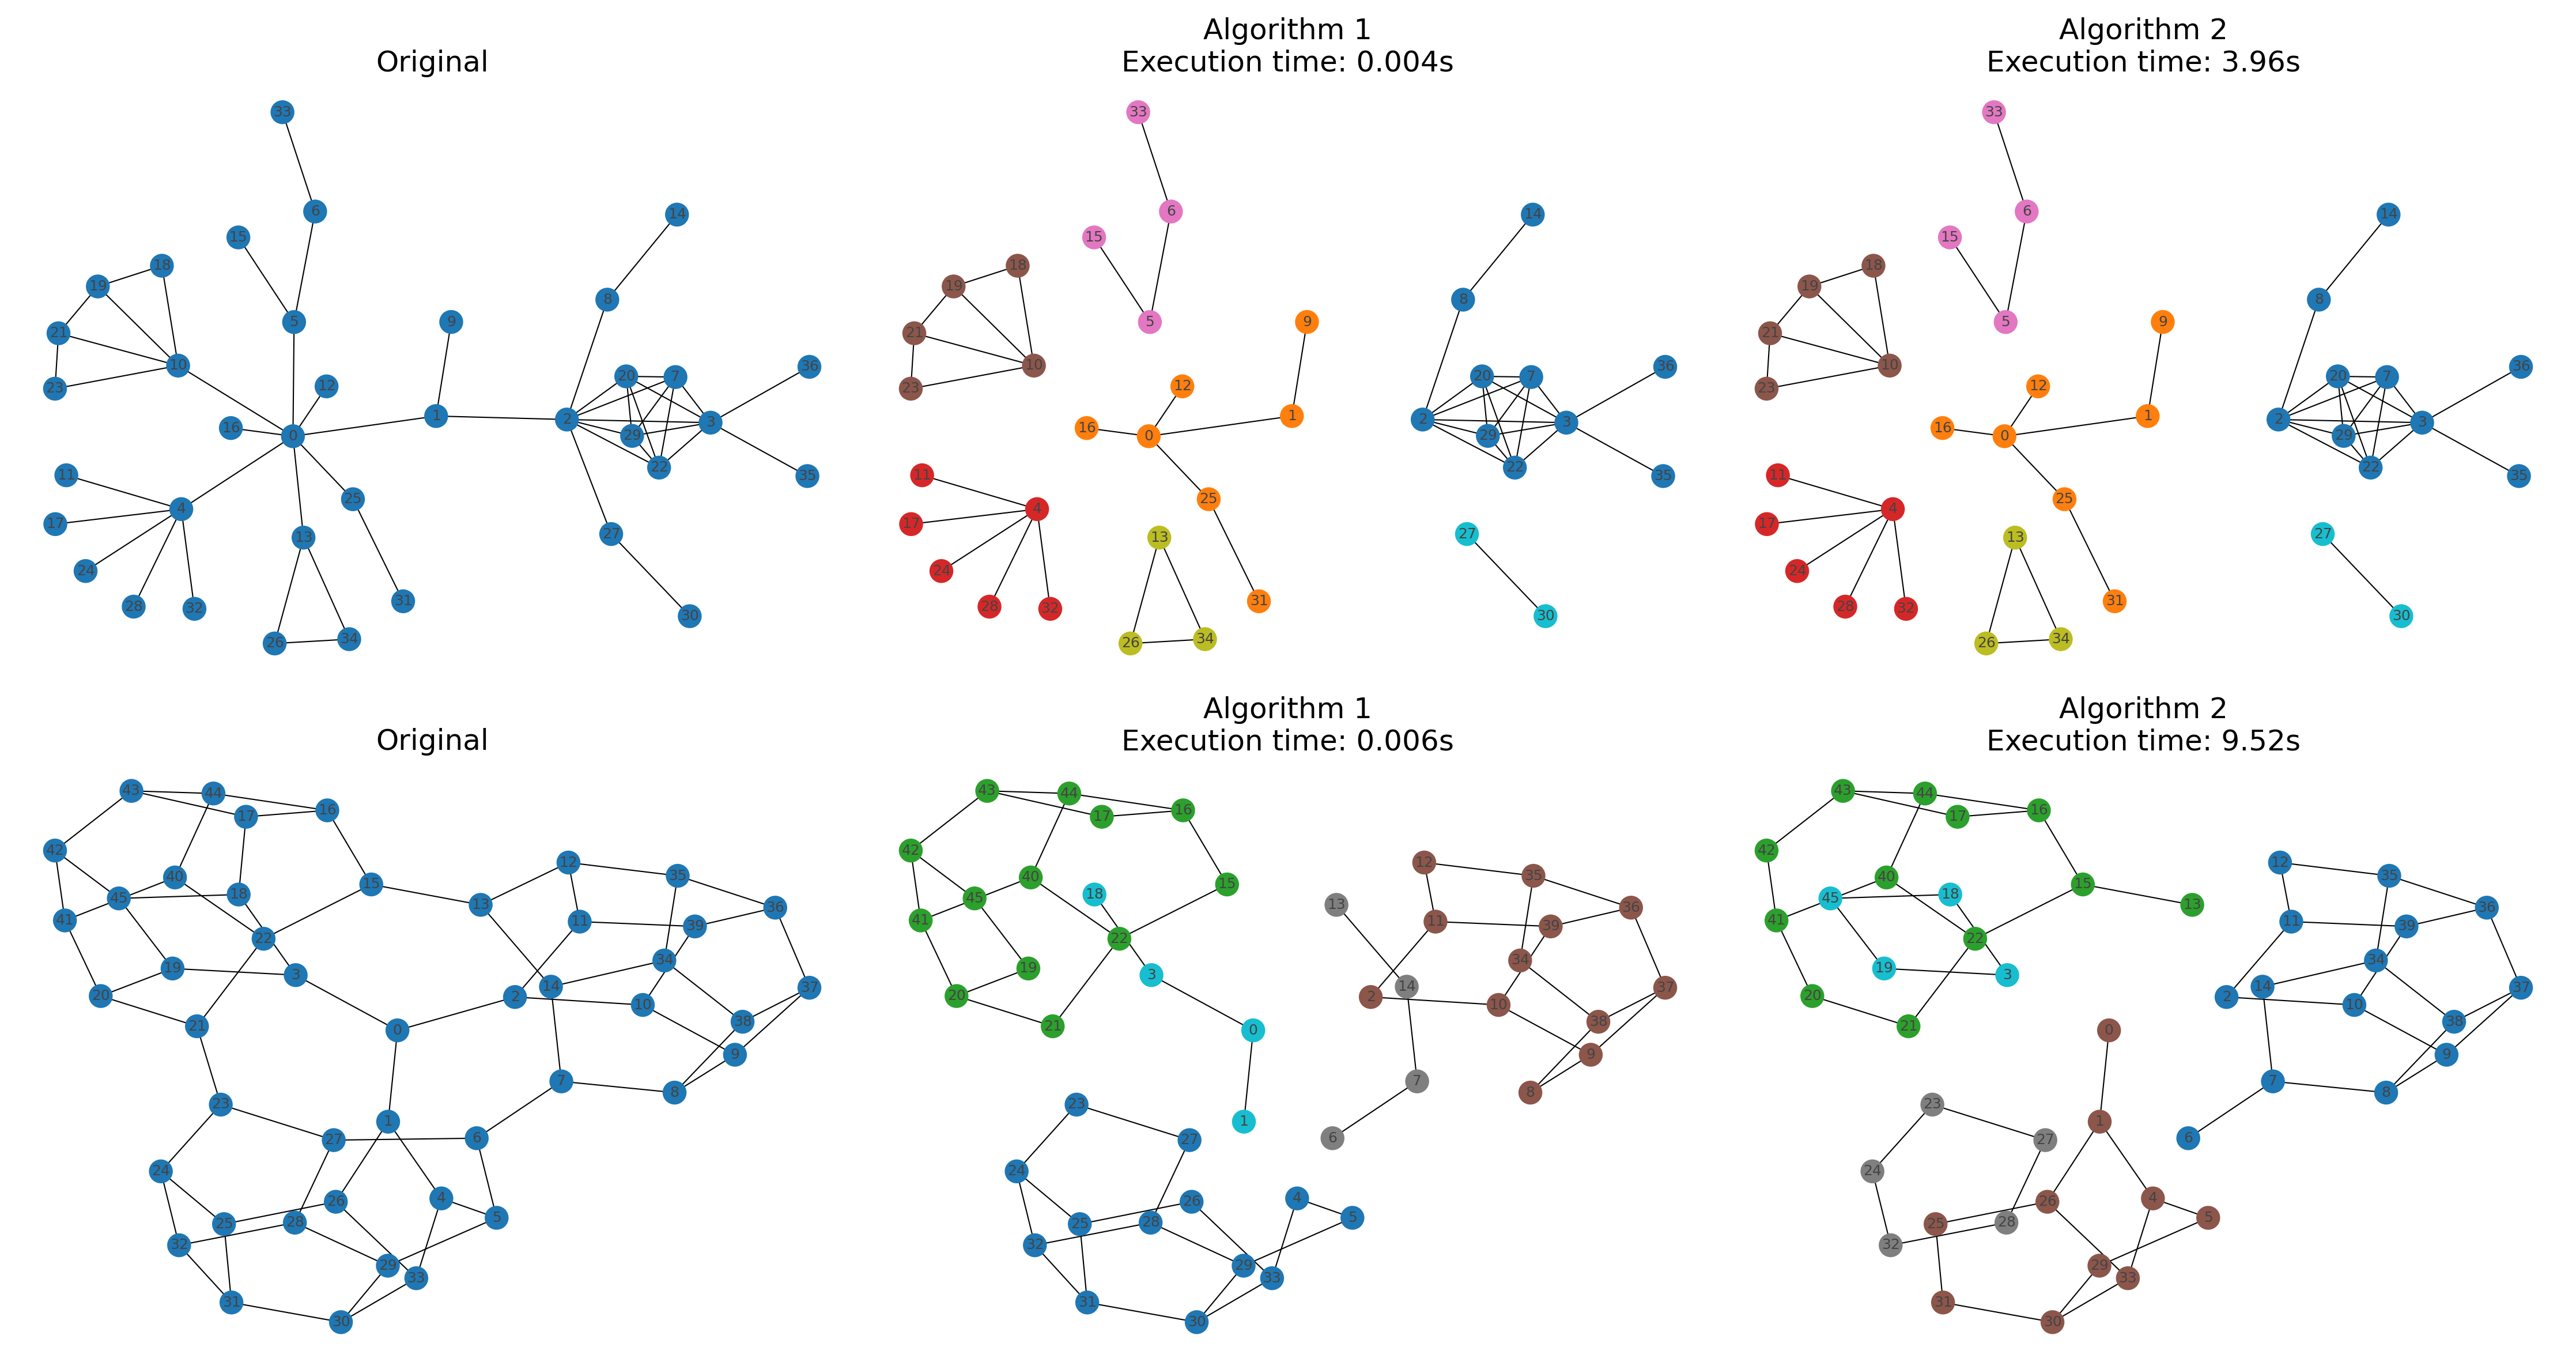

In [8]:
pos1 = nx.kamada_kawai_layout(sample1)
pos2 = nx.kamada_kawai_layout(sample2)
plt.figure(figsize=(15,8),dpi=300)                        
for i,net in enumerate([sample1,sample1_1,sample1_2,sample2,sample2_1,sample2_2]):
    values=[]
    v=1
    for cc in nx.connected_components(net):    
        for node in cc:
            values.append(v)
        v+=1
    plt.subplot(2,3,i+1)
    plt.title(net.name,fontsize=12)
    if(i<=2):
        nx.draw(net,pos=pos1,with_labels=1, font_size=6,font_color='#444',edge_color='black', width=0.5,node_size=80,node_color=values,cmap = plt.get_cmap('tab10'))
    else:
        nx.draw(net,pos=pos2,with_labels=1, font_size=6,font_color='#444',edge_color='black', width=0.5,node_size=80,node_color=values,cmap = plt.get_cmap('tab10'))
plt.tight_layout()
plt.savefig("ouput/2 community.png", format='png', dpi=550)
plt.savefig("ouput/2 community.svg", format='svg')
plt.savefig("ouput/2 community.pdf", format='pdf')
plt.show()

In [9]:
3.96/0.004, 9.52/0.006

(990.0, 1586.6666666666665)

# Attack Function

In [10]:
def getErroSTD(mr):
    #Calculate the variance.
    results=[r[1] for r in mr]
    resultsVariance=[]
    #results is a matriz. Each line is a repetion that contains 'howMany' values
    #The columns in this matriz are the values found in a point in time (f). So we the variance for each point 
    numberOfColumns = len(results[0])
    for col in range(numberOfColumns):
        colValues=[]
        for line in results:
            colValues.append(line[col])
        resultsVariance.append(np.std(colValues))   
    return resultsVariance

def rd_impact(G_original,repeat):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]
        listOfNode = list(G.nodes)
        rd.shuffle(listOfNode)#Randomize the nodes
        for i,_ in enumerate(range(len(listOfNode))):
            G.remove_node(listOfNode[i])
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)
            
        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])
        
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)    
    
    error=getErroSTD(matrizOfResults)
    plt.errorbar(xAxis,y,label='Random', yerr=error, ecolor='lightgreen', elinewidth=2, capsize=0,fmt='-',color='limegreen',linewidth=2)
    return matrizOfResults
  
def intentional_impact(G_original,repeat):
    matrizOfResults=[]
    for _ in range(repeat):
        G = G_original.copy()
        Nstart = G.number_of_nodes()
        yAxis=[1]
        xAxis=[0]

        #verticesOrdenados is a list of tuples (verticeName,degree)
        verticesOrdenados = list(dict(sorted(dict(G.degree).items(), key=lambda x:x[1],reverse=True)).items())
        #In case two or more hubs have the same degree
        first=verticesOrdenados[0]
        equalsToFirst=[first[0]]
        cont=1
        while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
            equalsToFirst.append(verticesOrdenados[cont][0])
            cont+=1
        #randomize the list of hubs that have the same degree
        rd.shuffle(equalsToFirst)
        verticeToRemove=equalsToFirst[0]

        for step in range(Nstart):    
            G.remove_node(verticeToRemove)
            Nactual = G.number_of_nodes()
            CCs = nx.connected_components(G)
            if Nactual != 0:
                LCC = max(CCs,key=len)
                #𝑃∞(𝑓)/𝑃∞(0)  = len(LCC)/Nstart # Because we start with a connect network, with only one connect component
                impact = len(LCC)/Nstart
            else:
                impact = 0 
            f = 1 - Nactual/Nstart
            yAxis.append(impact)
            xAxis.append(f)

            #verticesOrdenados is a list of tuples (verticeName,degree)
            verticesOrdenados = list(dict(sorted(dict(G.degree).items(), key=lambda x:x[1],reverse=True)).items())
            #In case two or more hubs have the same degree
            if(len(verticesOrdenados)>0):
                first=verticesOrdenados[0]
                equalsToFirst=[first[0]]
                cont=1
                while cont<len(verticesOrdenados) and first[1] == verticesOrdenados[cont][1]:
                    equalsToFirst.append(verticesOrdenados[cont][0])
                    cont+=1
                #randomize the list of hubs that have the same degree
                rd.shuffle(equalsToFirst)
                verticeToRemove=equalsToFirst[0]


        matrizOfResults.append([np.array(xAxis),np.array(yAxis)])

    #Calculate the average of all repeat
    y = np.array(matrizOfResults[0][1])
    for ex in matrizOfResults:
        y+=ex[1]
    y=y/(repeat+1)
    
    #Calculate de error and plotIT
    error=getErroSTD(matrizOfResults)

    plt.errorbar(xAxis,y,label='Hubs', yerr=error, ecolor='skyblue', elinewidth=2, capsize=0,fmt='-',color='blue',linewidth=2)
    
    return matrizOfResults



S1 Network Random
S1 Network Hubs
S2 Network Random
S2 Network Hubs


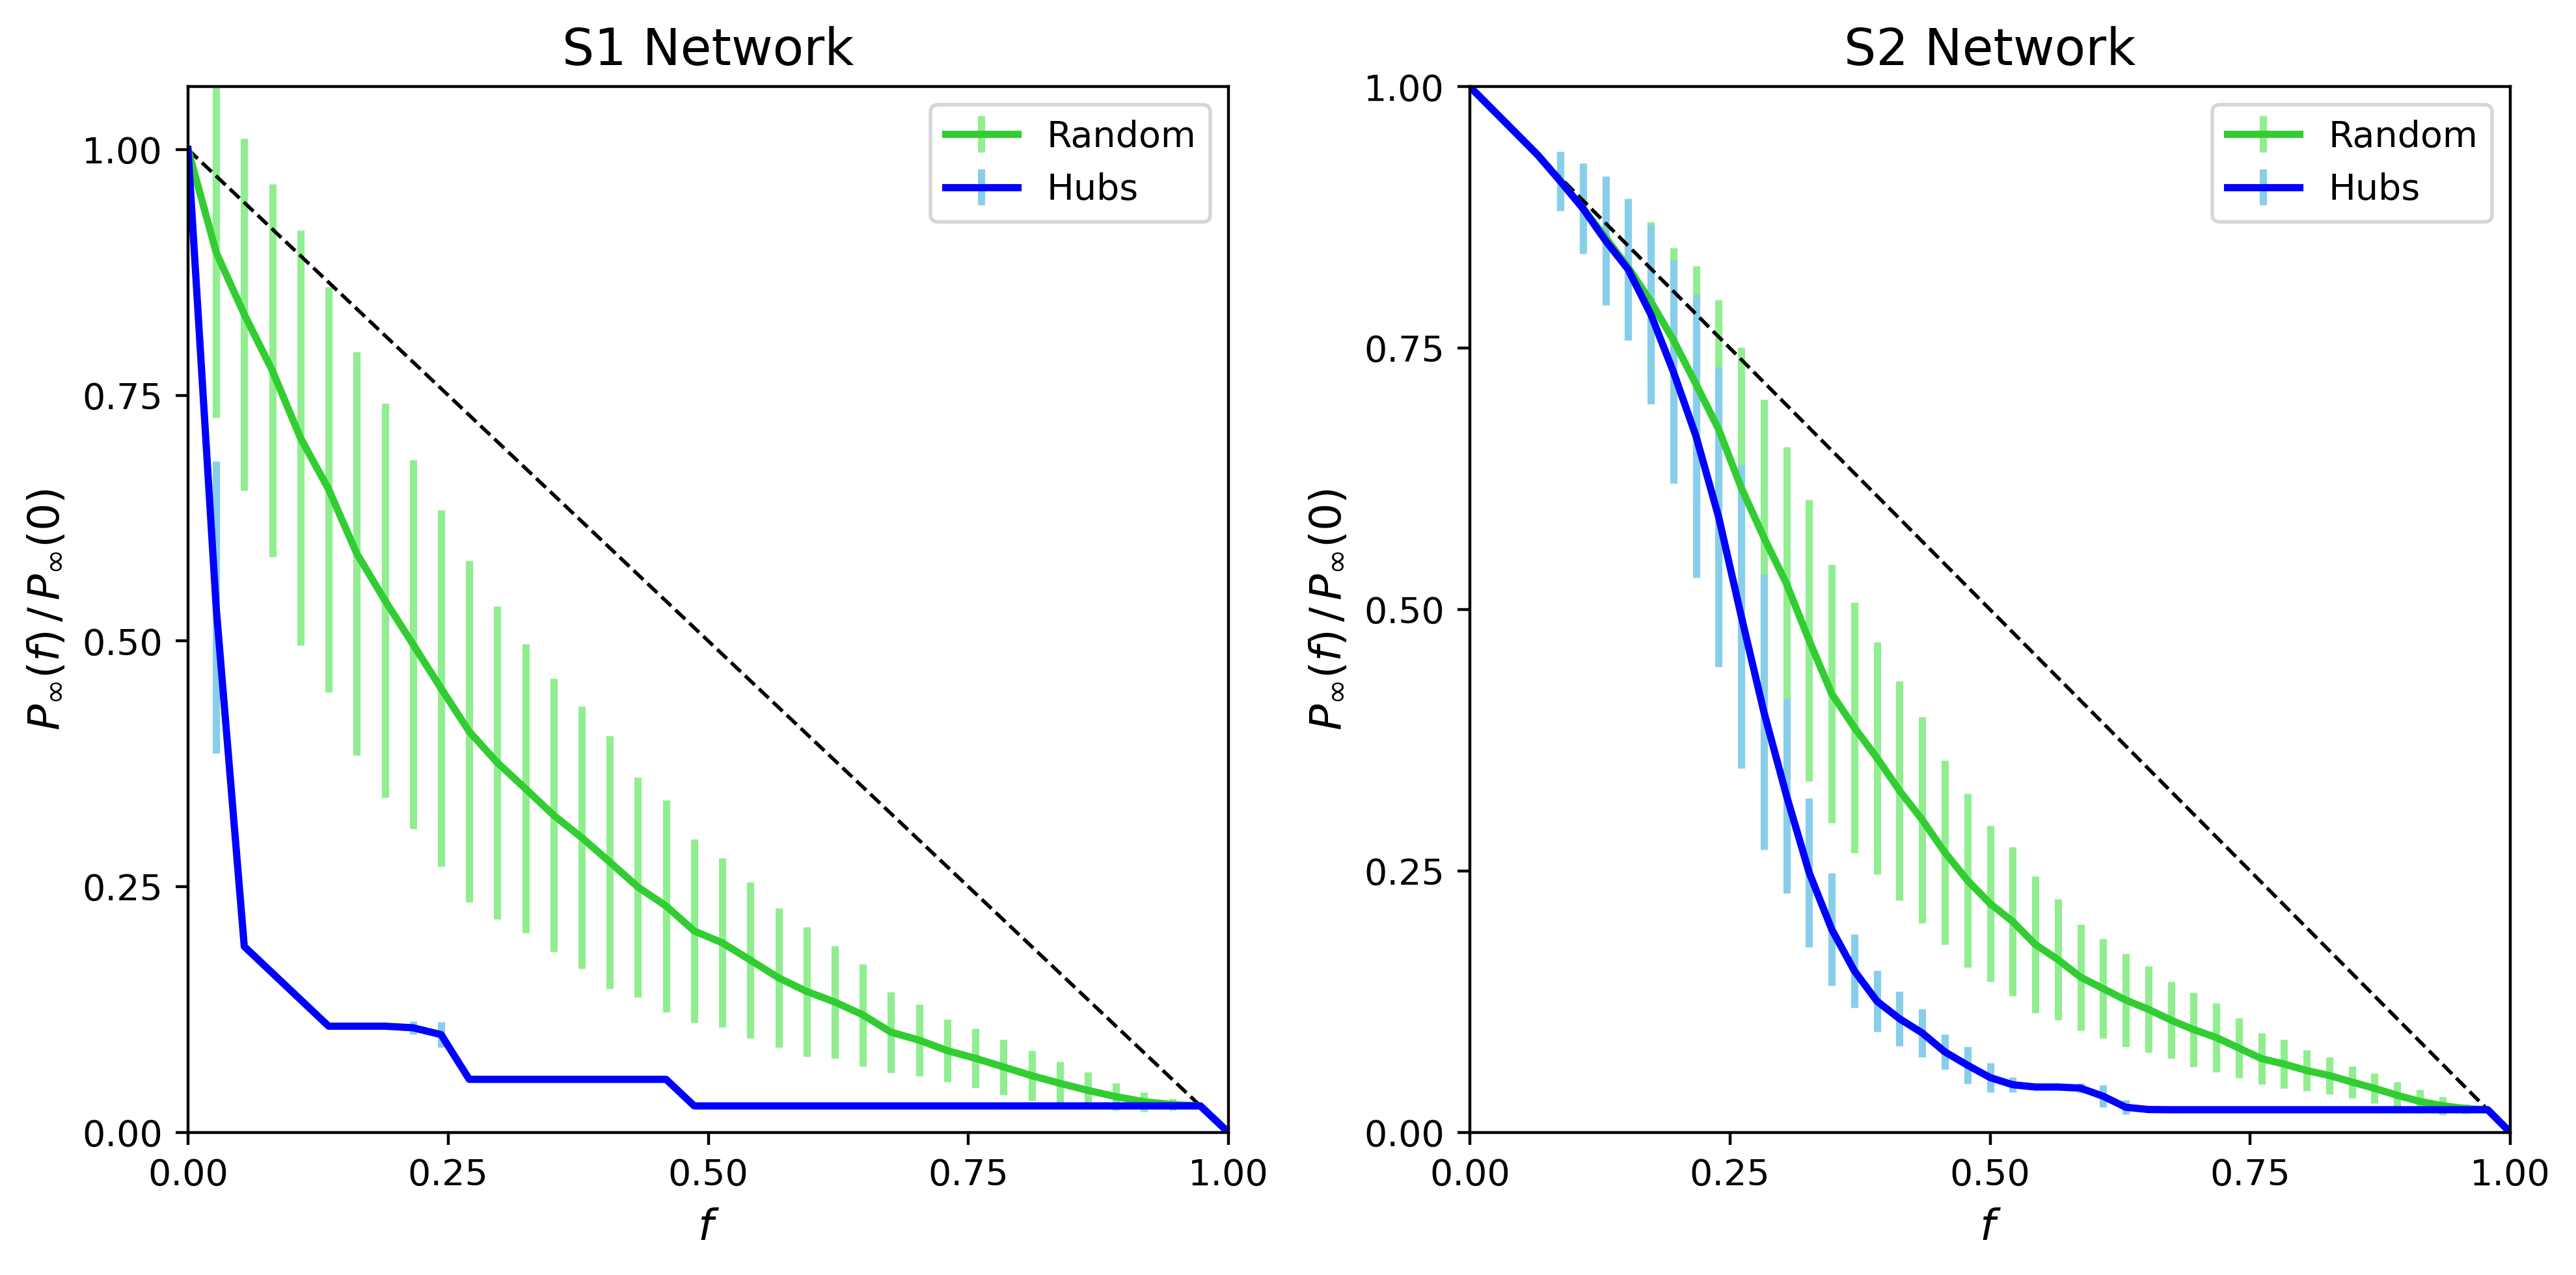

In [11]:
matrizOfImpacts={}
numberAttacksRandom=100
numberAttacksHub=100

plt.figure(figsize=(10,5),dpi=400)
sample1.name='S1 Network'
sample2.name='S2 Network'

for i,G in enumerate([sample1,sample2]):
    name=G.name
    LCC = nx.subgraph(G,max(nx.connected_components(G)))
    
    matrizOfImpacts[name]={}
    matrizOfImpacts[name]['Hubs']=[]
    matrizOfImpacts[name]['Random']=[]
    
    plt.subplot(1,2,i+1)
    
    matrizOfImpacts[name]['Random'].append(rd_impact(LCC,numberAttacksRandom))
    print(name+' Random')
    matrizOfImpacts[name]['Hubs'].append(intentional_impact(LCC,numberAttacksHub))
    print(name+' Hubs')
    
    plt.plot([0,1], [1,0], 'k--',linewidth=1)
    plt.margins(x=0)
    plt.margins(y=0)
    plt.yticks([0,0.25,0.5,0.75,1])
    plt.xticks([0,0.25,0.5,0.75,1])
    plt.ylabel(r'$P_{\infty}(f)\,/\, P_{\infty}(0)$',size=12)
    plt.xlabel(r'$f$',size=12)
    plt.title(LCC.name,fontsize=14)
    plt.legend()
    plt.tight_layout()

plt.tight_layout() 
plt.savefig("ouput/2 Attack.png", format='png', dpi=550)
plt.savefig("ouput/2 Attack.svg", format='svg')
plt.savefig("ouput/2 Attack.pdf", format='pdf')
plt.show()

# Assortativity

In [9]:
def averageNeighborsDegree(G,node):
    neighbors=list(nx.neighbors(G,node))
    if(len(neighbors)==0):
        return 0 
    else:
        return sum([nx.degree(G,n) for n in neighbors])/len(neighbors)

{8: [0, 2], 3: [1, 5, 13, 19, 21], 7: [3], 6: [4], 2: [6, 8, 18, 23, 25, 26, 27, 34], 5: [7, 10, 20, 22, 29], 1: [9, 11, 12, 14, 15, 16, 17, 24, 28, 30, 31, 32, 33, 35, 36]}
{8: 3.62, 3: 4.0, 7: 4.29, 6: 2.17, 2: 3.56, 5: 5.52, 1: 4.93}

{3: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]}
{3: 3.0}



C:\Users\Ramos\anaconda3\lib\site-packages\networkx\algorithms\assortativity\correlation.py:287: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / numpy.sqrt(vara * varb)


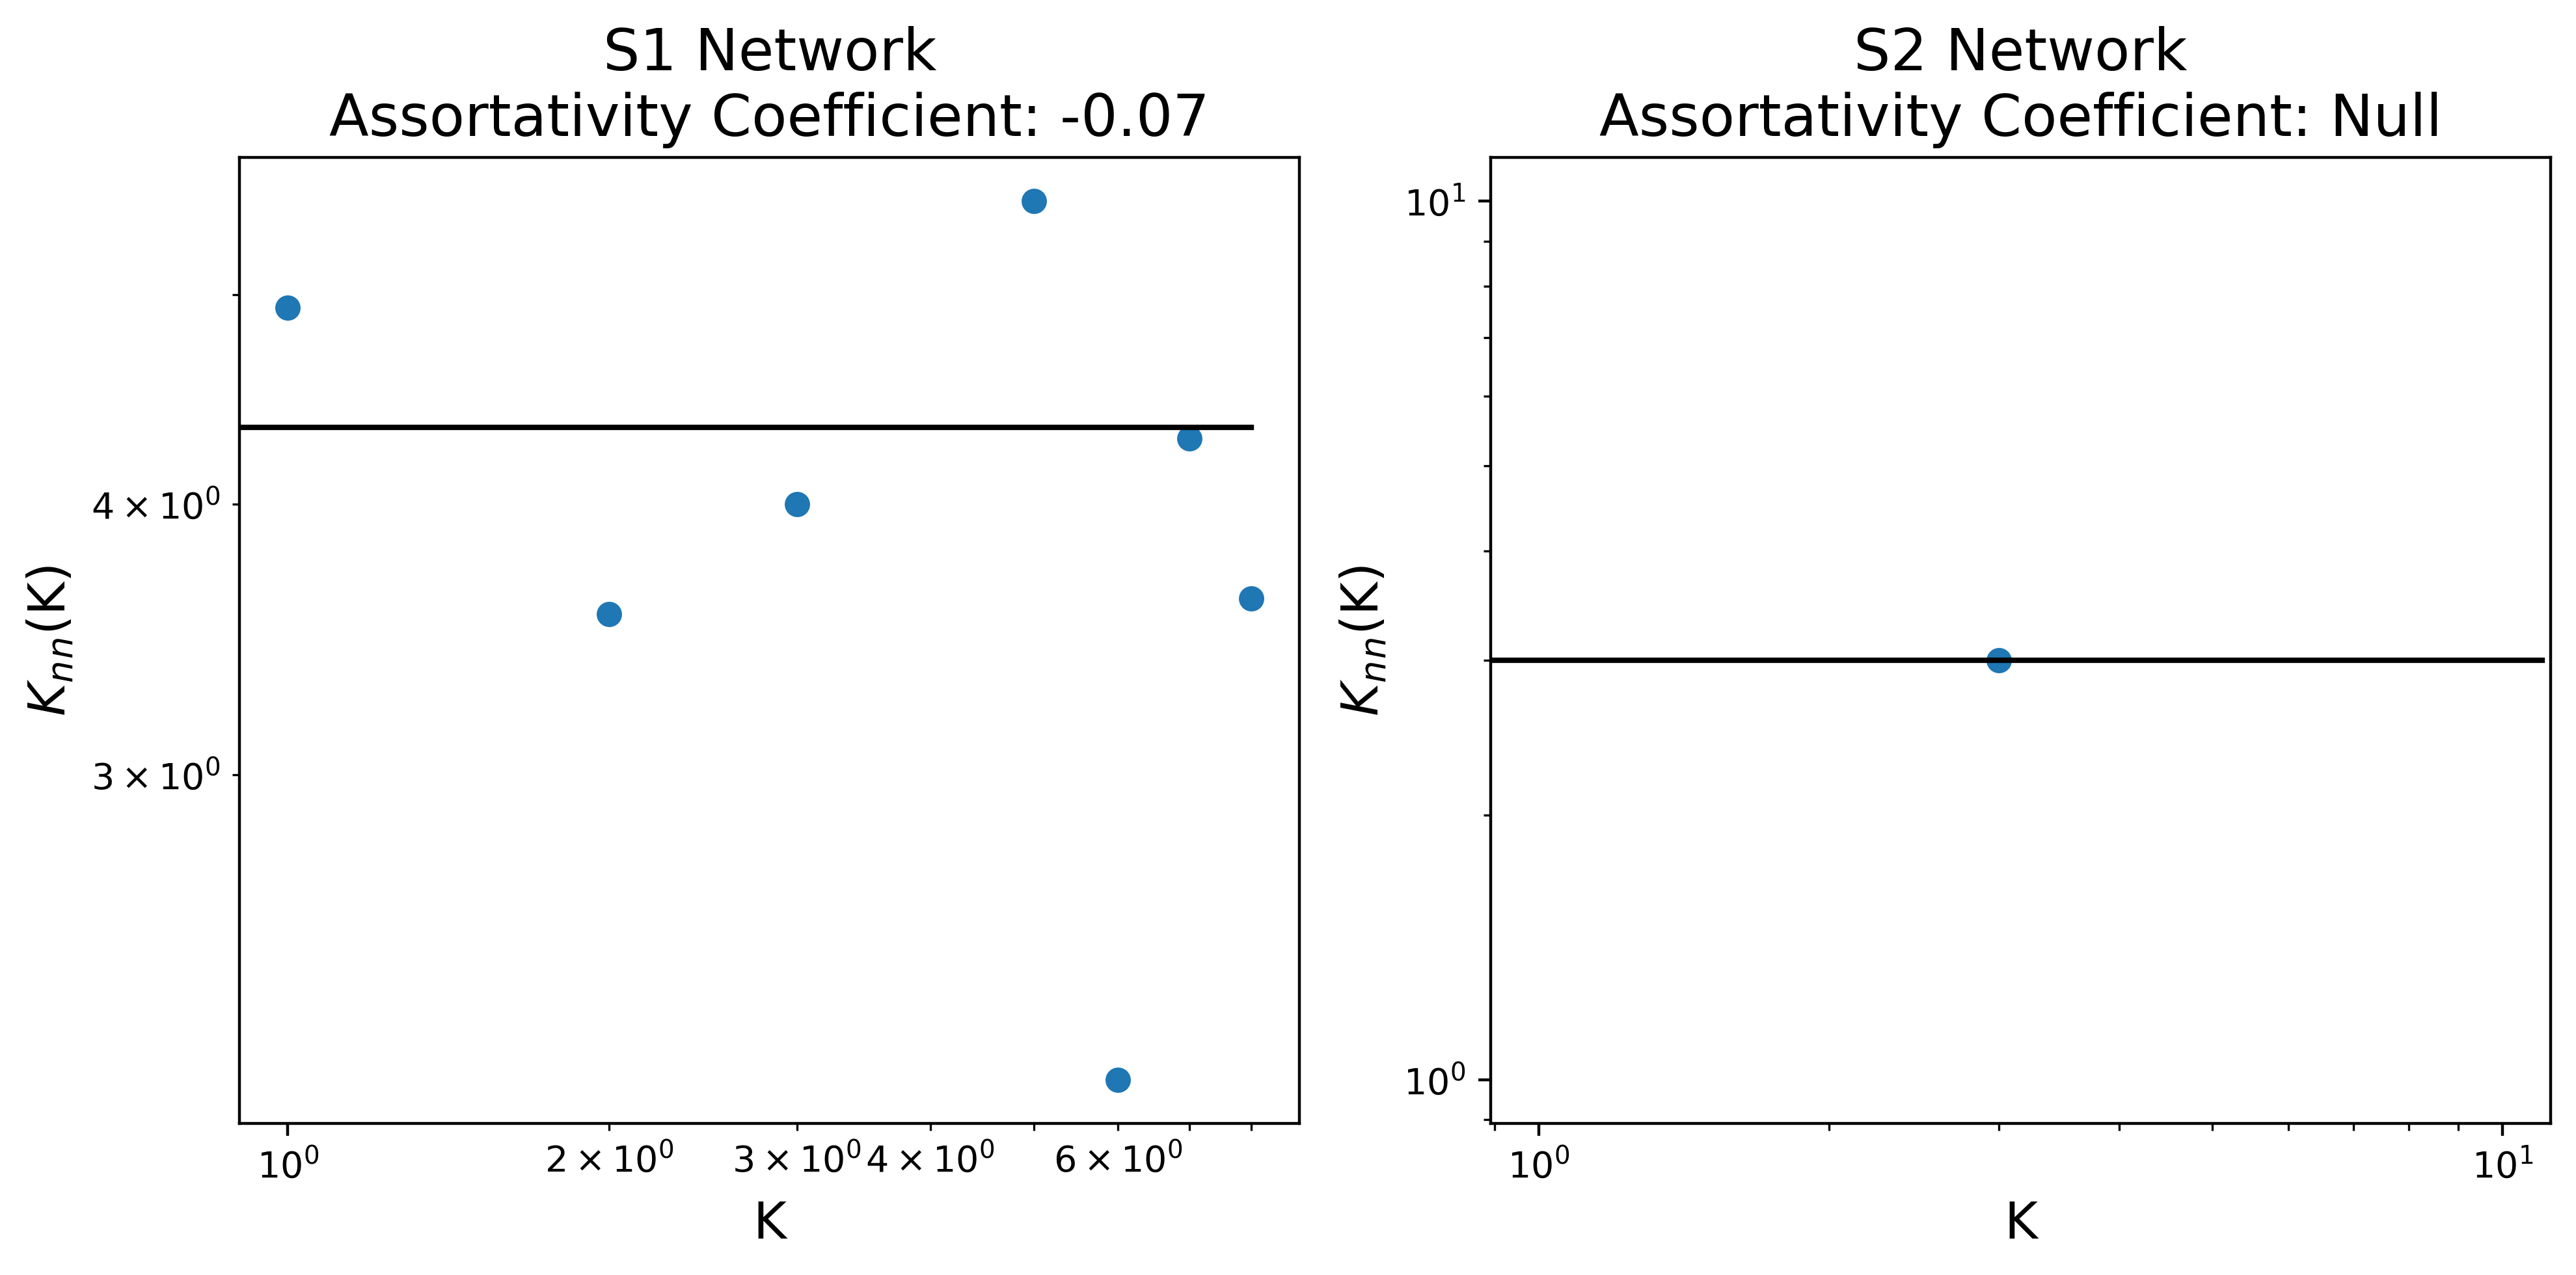

In [13]:
plt.figure(figsize=(10,5),dpi=400)
sample1.name='S1 Network'
sample2.name='S2 Network'

for i,G in enumerate([sample1,sample2]):
    plt.subplot(1,2,i+1)
    name=G.name
    #Get only the Largest Connect Component (LCC)
    G = nx.subgraph(G,max(nx.connected_components(G),key=len))
    nodeWithDegreeK={}
    #Get the nodes with degree 'k'
    for node,k in dict(G.degree).items():
        if k not in nodeWithDegreeK:
            nodeWithDegreeK[k]=[node]
        else:
            nodeWithDegreeK[k].append(node)
    print(nodeWithDegreeK)
    #Get the average neighbors degree for every node with degree'k'
    for k in nodeWithDegreeK:
        means=0
        for node in nodeWithDegreeK[k]:
            means+=averageNeighborsDegree(G,node)
        nodeWithDegreeK[k]=round(means/len(nodeWithDegreeK[k]),2)
    print(nodeWithDegreeK,end='\n\n')
    
    #Plot the distribution
    plt.loglog(list(nodeWithDegreeK.keys()),list(nodeWithDegreeK.values()),'o')

    #Plot the line for a random prediction
    degree = list(dict(G.degree).values())
    neutralNetwork=round((st.variance(degree) + st.mean(degree)**2)/st.mean(degree),2)
    ylim=plt.gca().get_ylim()
    xlim=plt.gca().get_xlim()
    randomPrediction=[neutralNetwork for x in range(int(xlim[1]*1.1))]    
    
    plt.loglog(range(int(xlim[1]*1.1)),randomPrediction,'-',color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('K',fontsize=14)
    plt.ylabel(r'$K_n$'r'$_n$(K)',rotation = 90,fontsize=14)
    assortativityCoeff = round(nx.assortativity.degree_assortativity_coefficient(G),2)
    if(np.isnan(assortativityCoeff)):
        assortativityCoeff='Null'
        
    plt.title(G.name+'\n'+'Assortativity Coefficient: '+str(assortativityCoeff),fontsize=16)
    plt.tight_layout()
    
plt.savefig("ouput/2 Assortatividade.png", format='png', dpi=550)
plt.savefig("ouput/2 Assortatividade.pdf", format='pdf')
plt.show()

In [15]:
(averageNeighborsDegree(sample1,0)+averageNeighborsDegree(sample1,2))/2

3.625

# Eccentricity

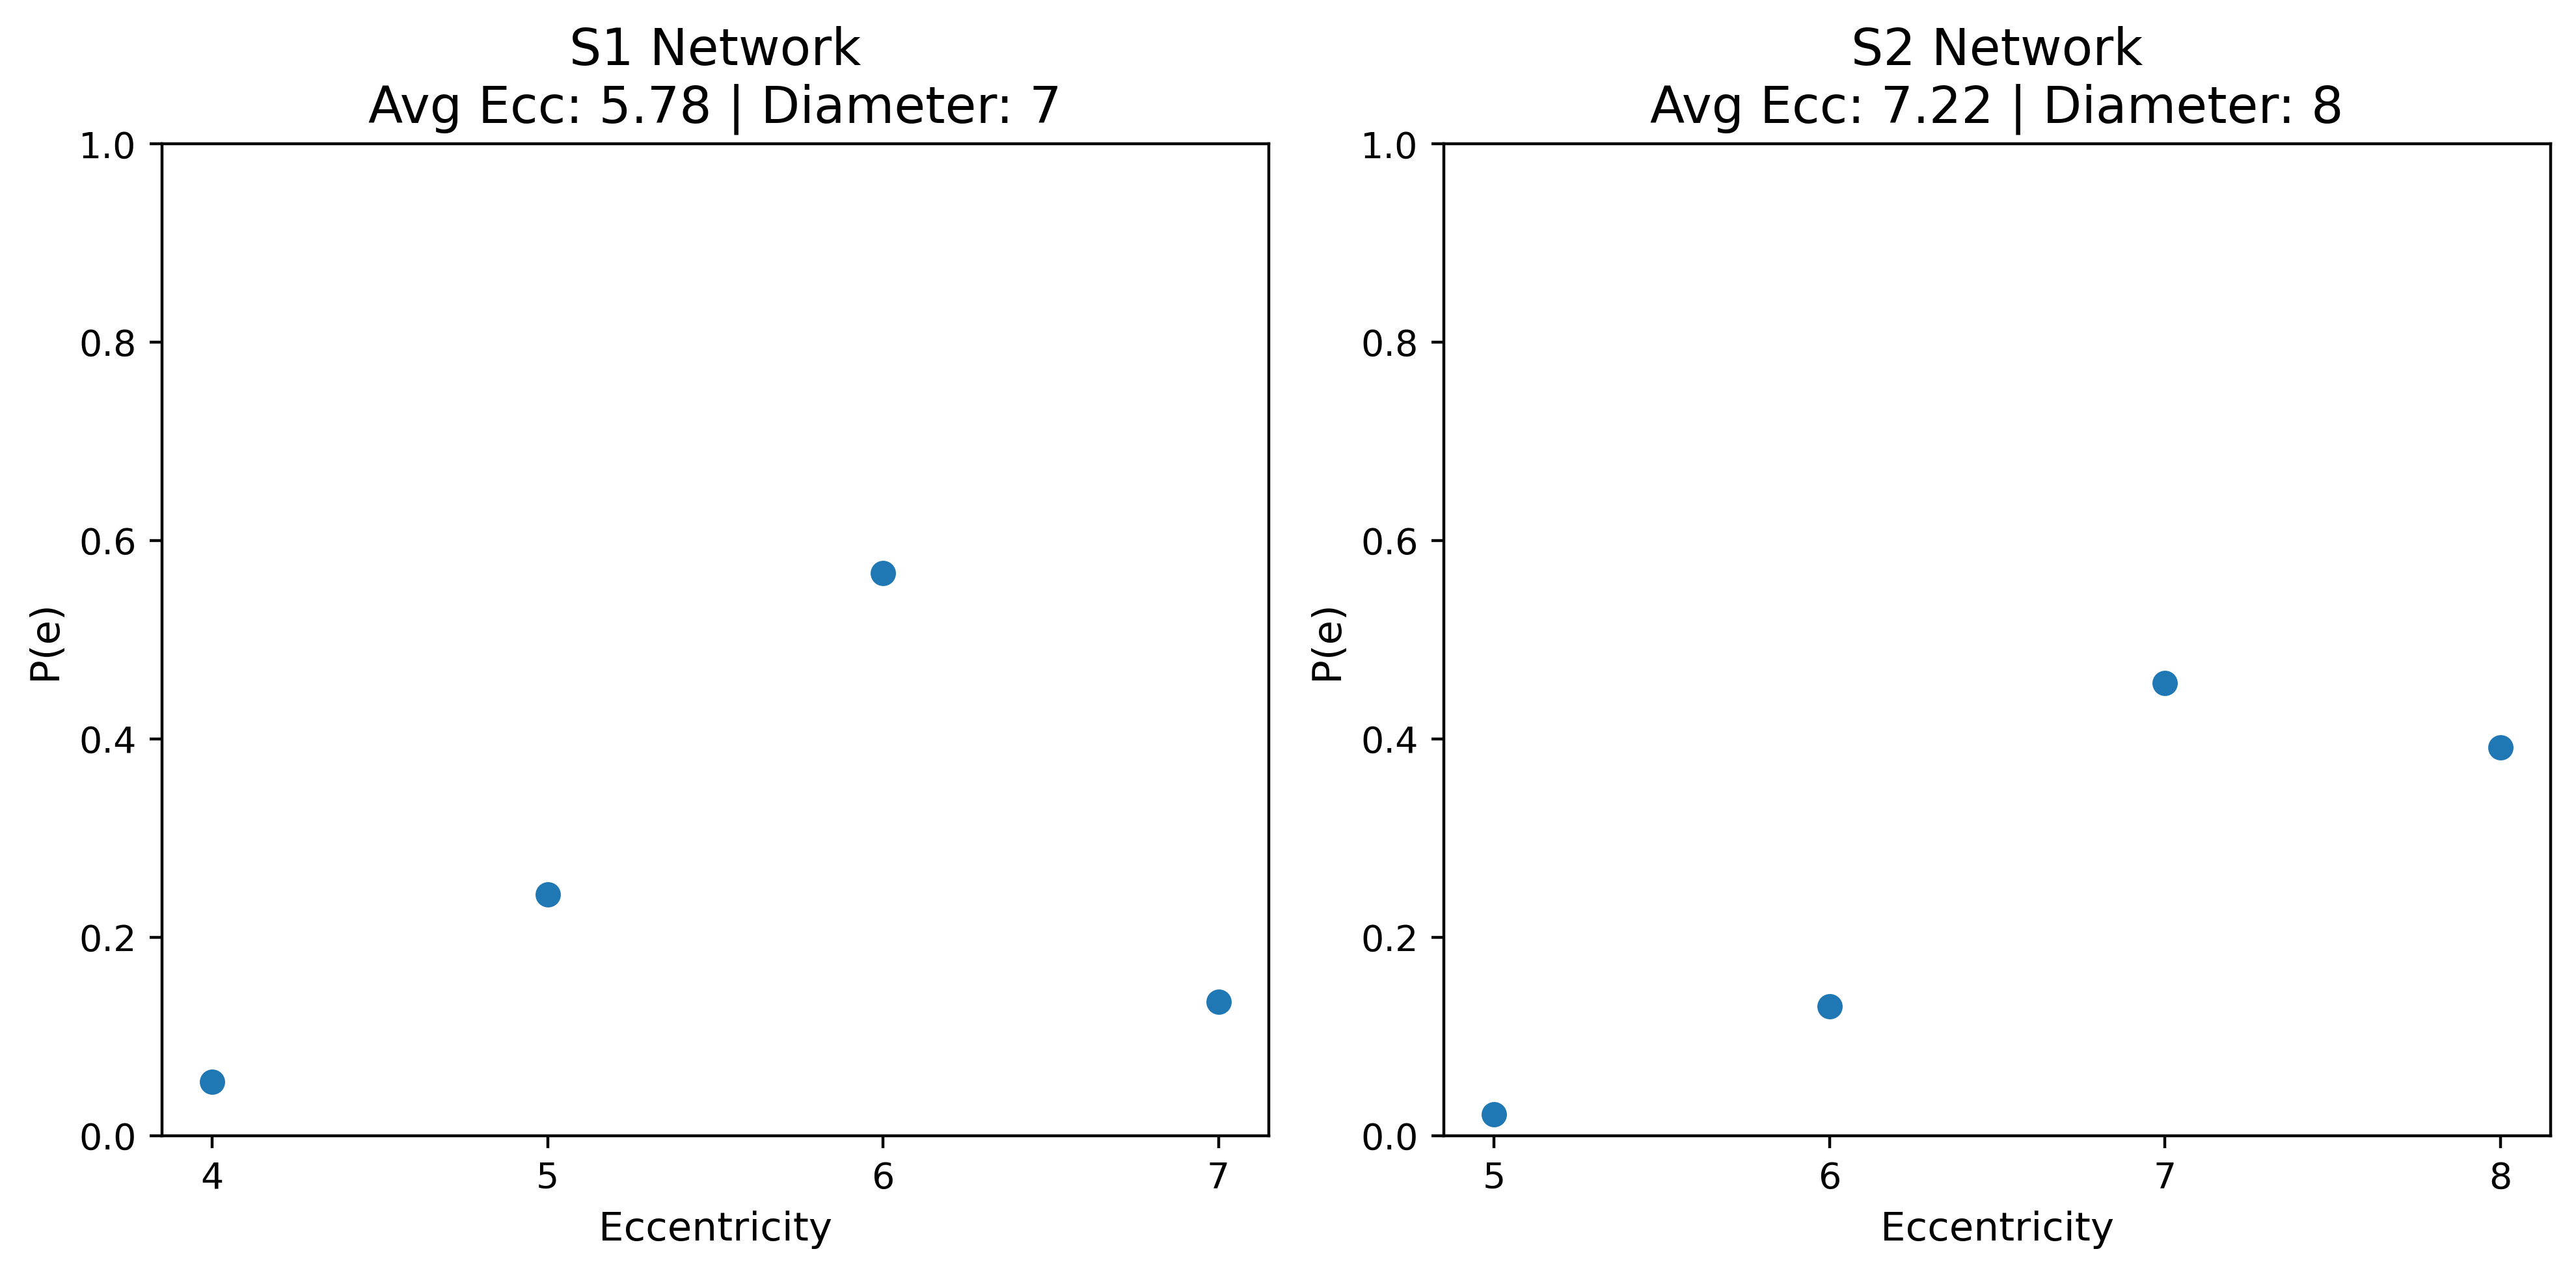

In [15]:
plt.figure(figsize=(10,5),dpi=400)
sample1.name='S1 Network'
sample2.name='S2 Network'

for i,G in enumerate([sample1,sample2]):
    plt.subplot(1,2,i+1)
    name=G.name
    
    ecc=list(nx.eccentricity(G).values())
    avgSP = round(np.mean(ecc),2)
    diameter=round(max(ecc))

    eccentricityProb={}
    total = len(ecc)
    for c in ecc:
        if c in eccentricityProb:
            eccentricityProb[c]+=1
        else:
            eccentricityProb[c]=1

    for c in eccentricityProb:
        eccentricityProb[c]=eccentricityProb[c]/total

    eccentricityProb = dict(sorted(eccentricityProb.items(), key=lambda x:x[0]))

    plt.plot(list(eccentricityProb.keys()),list(eccentricityProb.values()),'o')
    plt.yticks(np.arange(0,1.1,0.2))
    plt.xticks(sorted(set(ecc)))
    plt.xlabel("Eccentricity",fontsize=11)
    plt.ylabel("P(e)",fontsize=11)
    plt.title(name+'\nAvg Ecc: '+str(avgSP)+' | Diameter: '+str(diameter),fontsize=14)
    plt.tight_layout()

plt.savefig("ouput/2 Eccentricity.png", format='png', dpi=550)
plt.savefig("ouput/2 Eccentricity.pdf", format='pdf')
plt.show()

# Clustering and Density

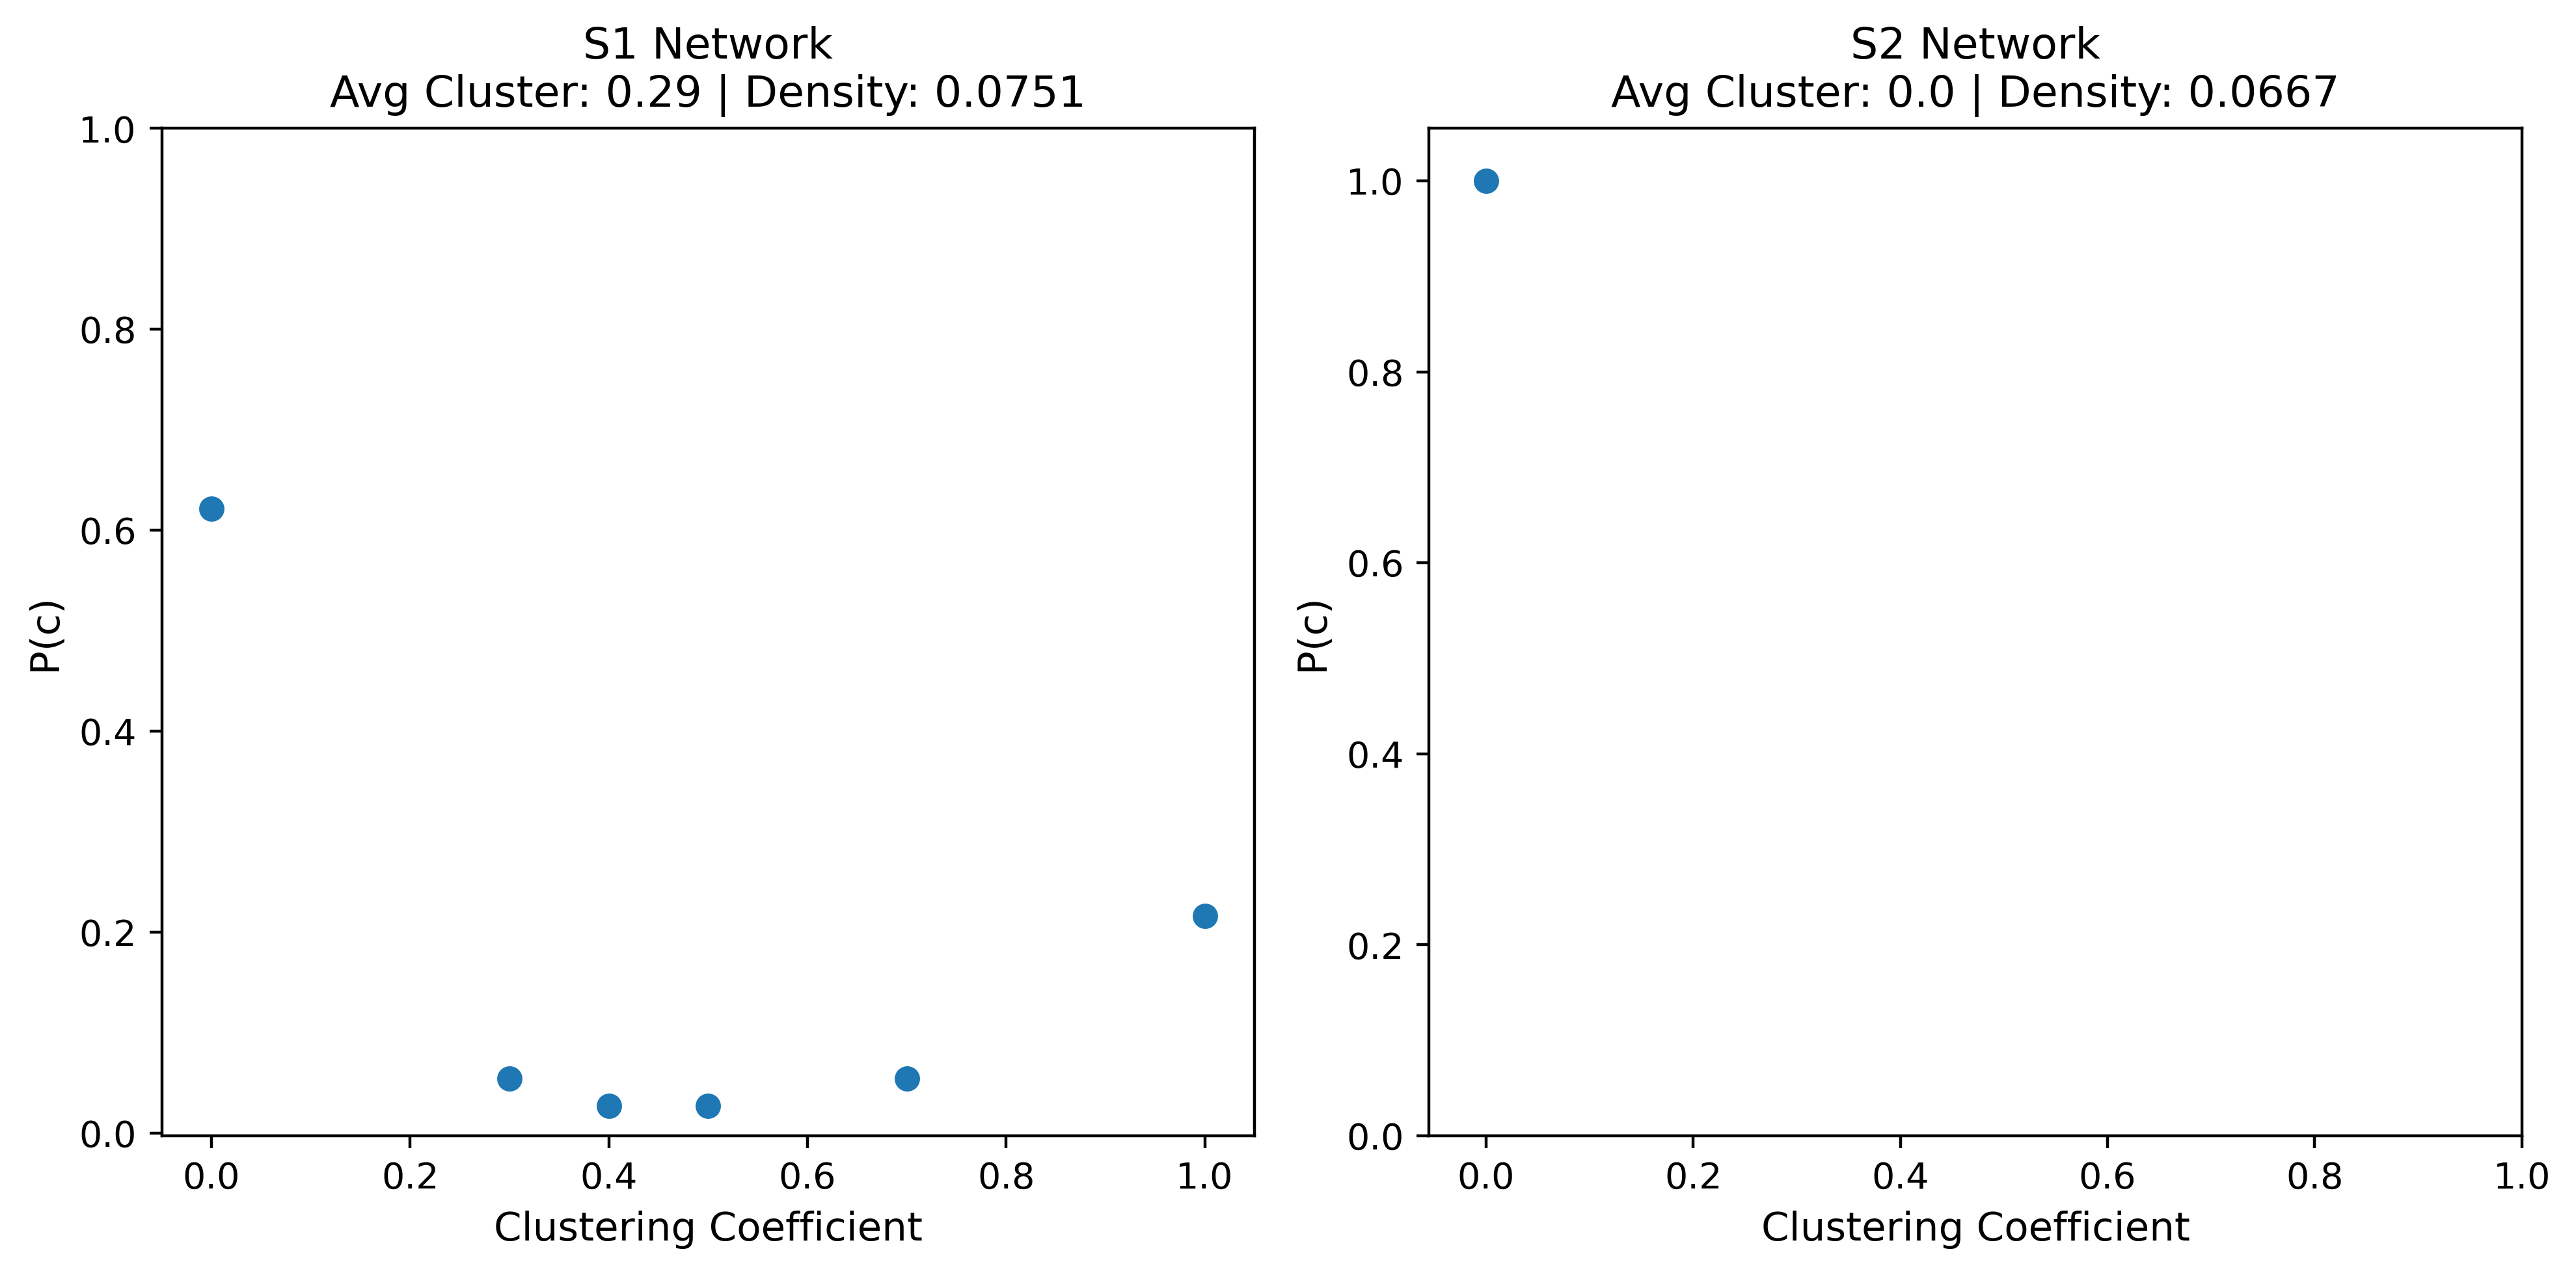

In [16]:
plt.figure(figsize=(10,5),dpi=400)
sample1.name='S1 Network'
sample2.name='S2 Network'

for i,G in enumerate([sample1,sample2]):
    plt.subplot(1,2,i+1)
    name=G.name
    
    cluster=list(nx.clustering(G).values())
    
    mean = round(np.mean(cluster),2)
    clusterProbCount = [round(c,1) for c in cluster]

    clusterProb={}
    total = len(clusterProbCount)
    for c in clusterProbCount:
        if c in clusterProb:
            clusterProb[c]+=1
        else:
            clusterProb[c]=1

    for c in clusterProb:
        clusterProb[c]=clusterProb[c]/total

    clusterProb = dict(sorted(clusterProb.items(), key=lambda x:x[0]))

    plt.plot(list(clusterProb.keys()),list(clusterProb.values()),'o')
    plt.xticks(np.arange(0,1.1,0.2))
    plt.yticks(np.arange(0,1.1,0.2))
    plt.xlabel("Clustering Coefficient",fontsize=11)
    plt.ylabel("P(c)",fontsize=11)
    plt.title(name+'\nAvg Cluster: '+str(mean)+' | Density: '+str(round(nx.density(G),4)),fontsize=12)
    plt.tight_layout()
    
plt.savefig("ouput/2 Clustering.png", format='png', dpi=550)
plt.savefig("ouput/2 Clustering.pdf", format='pdf')
plt.show()